In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from models.cnn_base import CNNBaseModel

# import wavemix
# from wavemix.classification import WaveMix

CKPT_SAVE_PATH = "model_ckpts/ocr_letters.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
class_map = {
    "0": "A",
    "1": "B",
    "2": "C",
    "3": "D",
    "4": "E",
    "5": "F",
    "6": "G",
    "7": "H",
    "8": "I",
    "9": "J",
    "10": "K",
    "11": "L",
    "12": "M",
    "13": "N",
    "14": "O",
    "15": "P",
    "16": "Q",
    "17": "R",
    "18": "S",
    "19": "T",
    "20": "U",
    "21": "V",
    "22": "W",
    "23": "X",
    "24": "Y",
    "25": "Z"
}


In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST balanced dataset
data_root = './data'
emnist_data = datasets.EMNIST(root=data_root, split='letters', train=True, download=True, transform=transform)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(emnist_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(emnist_data, batch_size=batch_size, shuffle=False )

# Iterate through the data
for images, labels in train_loader:
    print(images.shape)  # Output: (batch_size, 1, 28, 28)
    print(labels.shape)  # Output: (batch_size,)
    break  # Just to see one batch

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
print(f"Number of classes {len(emnist_data.classes)} \n (1 extra class for NaN)")

Number of classes 27 
 (1 extra class for NaN)


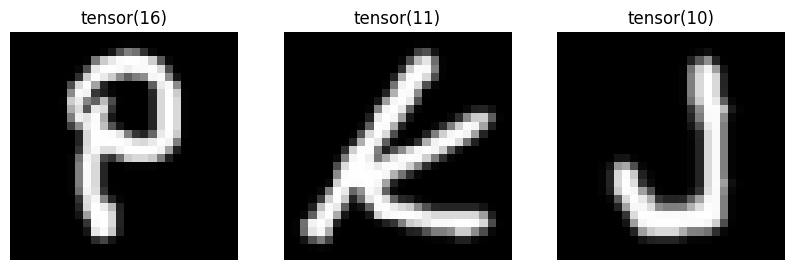

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8)) 

for i in range(3):
    axs[i].imshow(images[i].squeeze().T, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(labels[i])
plt.show()

In [9]:
model = CNNBaseModel()
# model = WaveMix(
#     num_classes= 27, 
#     depth= 16,
#     mult= 2,
#     ff_channel= 192,
#     final_dim= 112,
#     dropout= 0.5,
#     level=1,
#     patch_size=2,
# )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2
model.to(device)

CNNBaseModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=27, bias=True)
)

In [10]:
def train():
    best_val = 0
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for images, labels in tqdm(train_loader, desc="Training"):
            images = images.transpose(-1, -2)
#             plt.imshow(images[0].squeeze(0).squeeze(0), cmap='gray')
#             plt.title(class_map[str(labels[0].item() - 1)])
#             plt.show()
#             return
            # if isinstance(model, WaveMix):
            #     images = images.repeat(1, 3, 1, 1)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for val_images, val_labels in tqdm(val_loader, desc="Evaluating"):
                val_images = val_images.transpose(-1, -2)
                # if isinstance(model, WaveMix):
                #     val_images = val_images.repeat(1, 3, 1, 1)
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)  # Forward pass
                val_loss = criterion(val_outputs, val_labels)  # Calculate validation loss
                
                running_val_loss += val_loss.item()  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(val_outputs.data, 1)  # Get the index of the max log-probability
                total += val_labels.size(0)  # Total number of labels
                correct += (predicted == val_labels).sum().item()  # Count correct predictions

        # Calculate average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        accuracy = correct / total * 100  # Percentage

        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
        if accuracy > best_val:
            torch.save(model.state_dict(), CKPT_SAVE_PATH)
            print(f"Better model Accuracy saved")

    print("Training and validation complete!")

In [11]:
train()

Training:  12%|█▏        | 241/1950 [00:13<01:38, 17.33it/s]


KeyboardInterrupt: 